# <center> <font color='lightseagreen'> Circadian Clock Linked Hypocotyl Elongation Model </font>

<center> <b> Chloe Bantock</b>  <br>
Master in Bioinformatics and Computational Biology, UAM.<br>  
Course 2021-2022 </center> 


***


**Modelling the effects of circadian clock regulation of ELF3 and COP1 expression on hypocotyl elongation in *Arabidopsis thaliana***

Recent advances in computational and experimental studies of the circadian clock in  Arabidopsis thaliana have led to new models of the clock gene network that include a three-component repressilator circuit (Pokhilko et al., 2012). This new circadian clock model of Pokhilko et al. (2012) suggests that the plant clock functions as an integrated, multi-feedback system that maintains robust oscillations and entrainment under multiple perturbations. <br>

The main objective of this master’s thesis will be to integrate the model developed by Pokhilko et al. (2013) with one developed by Cristina Nieto et al. (2021) for modeling light and temperature cues in hypocotyl elongation. This is possible as hypocotyl elongation is subject to photoperiodic regulation by the circadian clock through PIF4 and PIF5 (phytochrome interacting factors) transcription (Seaton et al., 2015). The integration of these two models would allow us to take a holistic approach to understanding the circadian clock through its interaction in output pathways. Further simulation and analysis of this coupled model would highlight the underlying molecular mechanisms that coordinate plant growth across changing conditions and may provide insights into the overall contribution of the clock to plant fitness. Future advancements in this area may in turn enable one to engineer aspects of plant physiology for improved growth in both existing and new environments (Seaton et al., 2015). 

<font color="coral"><h3> **Code**</font>

The following sections include: 
  
1.   [Replicating results from hypocotyl elongation model](#replicating)
      -   Mutation Simulations
      -   Protein Dynamics in Short Day 
      -   Protein Dynamics in Long Day
2.   [Calling Matlab Code from Python](#calling_matlab) 
3.   [Clock Linked Growth Model (MATLAB)](#joint_matlab_model)
      -   Comparison to original growth model 

In [241]:
#imports

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mticker
prop = fm.FontProperties(fname='/usr/share/fonts/truetype/Mark Simonson - Proxima Nova Alt Regular-webfont.ttf')
import pylab
import numpy as np
#!pip install seaborn
import seaborn as sns
from scipy.integrate import odeint
import itertools
import subprocess
import pandas as pd
import requests
import io
import openpyxl

import matlab.engine

from platform import python_version
print(python_version())
import sys
sys.executable

3.8.13


'/Users/chloe/miniforge3/envs/rosetta/bin/python'

<a id='replicating'></a>
## <font color='lightseagreen'> REPLICATING RESULTS FROM HYPOCOTYL ELONGATION MODEL </font>

Code from [Pablo Catalan](https://github.com/PabloCatalan/hypocotyl)

In [5]:
# retrieve experimental data
day_length_data_url = 'https://raw.githubusercontent.com/PabloCatalan/hypocotyl/main/data/daylength_def.csv'
day_length_data = requests.get(day_length_data_url).content
DF = pd.read_csv(io.StringIO(day_length_data.decode('utf-8')))

In [6]:
def get_key(df, key):
    '''
    given a dataframe and key (ie column name), returns a list containing 
    all values of the specified key. For example, calling get_key(DF, 'Genotype') would 
    return a list containing all Genotypes found in the experimental data
    '''
    kL=df[key].tolist()
    kM={}
    for k in kL:
        kM[k]=1
    kL=[]
    for k in kM:
        kL.append(k)
    return sorted(kL)

def read_data():
    '''
    returns the average growth and standard deviation in growth for each growth condition in 
    each mutant type in the experimental data (where the growth condition refers to the
    temperature and light conditions)
    '''
    #DF=pd.read_csv('data/daylength_def.csv')
    mut=get_key(DF,'Genotype')
    Length=get_key(DF,'Daylength')
    Temp=get_key(DF,'Temperature')    
    avgdata={}
    stddata={}
    for m in mut:
        DFm=DF[DF.Genotype==m]
        m=m.replace(' ','_')
        avgdata[m]={}
        stddata[m]={}
        # what does itertools.prodcut do???
        for d,t in itertools.product(Length,Temp):
            key=str(t)+'_'+str(d)
            DFnew=DFm[(DFm.Daylength==d) & (DFm.Temperature==t)]
            avgdata[m][key]=DFnew.Growth.mean()
            stddata[m][key]=DFnew.Growth.std()
    return avgdata, stddata

def is_day(t,Daylength):
    '''
    the light parameter can take one of two values – 0 at night, or 1 during daytime.
    Thus, the function returns 1 - soln to the heavyside function, which is given by: 
            t1 < 0,  = 0 (daytime)
            t1 == 0, = 0 (daytime)
            t1 > 0,  = 1 (nightime)
    '''
    t1=t%24-Daylength
    return 1-np.heaviside(t1,1)

# elf3 protein dynamics
def elf3p(t,Daylength,pE1,pE2):  
    k0=5
    t2=t-Daylength
    t3=t-24.0
    
    if Daylength==0:
        return pE1+pE2
    elif Daylength==24:
        return pE1-pE2    
    else:
        SigT=2.0/(1.0+np.exp(-k0*t))
        SigT2=2.0/(1.0+np.exp(-k0*t2))
        SigT3=2.0/(1.0+np.exp(-k0*t3))
        return pE1-pE2*(-1.0+SigT-SigT2+SigT3)

    
# where t a timepoint in parameter 'time' as defined when calling the odeint solver (120 hours, 500 timepoints)    
    
def growth(y, t, Temp, Day, mut, pB28, kr22, kr28, pE122, pE128,
           pE222, pE228, dE, pPE22, pPE28, dP, kPC, dPB, pCL28,
           pCD, dC, pG, kG, pGP, pGE, pGB, pGH, pHC, mutBox,
           mutEox, mutPox, mutPko1, mutPko2, mutCox, mutCko1,
           mutCko2):
    '''
    y is an array containing [PHYB], [ELF3], [PIF], [COP1], and growth (m) - protein concentrations are non-dimensional 
    parameters that are a function of T will have different values at 22C and 28C 
    For a given species K, dk = decay rate 
    mutk is a multiplier that alters moleccule K's production to accomodate knout and over-expressor lines
    '''
        
    #Variables
    B=y[0]#PHYB
    E=y[1]#ELF3
    P=y[2]#PIF
    C=y[3]#COP1
    G=y[4]#Hypocotyl
    
    #Parameters
    # t1 is the hour in the day 
    t1=t%24
    L=is_day(t1,Day)
    pB=10.0
    kr=kr22#0.232 datos de Casal
    pE1=pE122#adimensional
    pE2=pE222
    pP=1.0#adimensional
    pPE=pPE22
    pCL=1.0#adimensional
    mB=1.0#maximum PHYB value
    if Temp==28:
        pB=pB28
        kr=kr28#0.411 datos Casal
        pE1=pE128
        pE2=pE228
        pPE=pPE28
        pCL=pCL28
    if 'PHYBox' in mut:
        mB*=mutBox
    if 'ELF3ox' in mut:
        pE1*=mutEox
    if 'PIF4ox' in mut:
        pP*=mutPox
    if 'pif4' in mut:
        pP*=mutPko1
    if 'pifq' in mut:
        pP*=mutPko2
    if 'COP1' in mut:
        pCL*=mutCox
        pCD*=mutCox
    if 'cop1-4' in mut:
        pCL*=mutCko1
        pCD*=mutCko1
    if 'cop1-6' in mut:
        pCL*=mutCko2
        pCD*=mutCko2
    if 'hy5' in mut:
        pGH=0
        
    #Equations (all are nuclear proteins)
    
    # active form of phyB, Pfr
    # where pB is rate of activation and translocation to nuclues 
    # kr is the rate of dark reversion (assume happens during day and night)
    dBdt=pB*L*(mB-B)-kr*B
    
    # ELF3p concentration 
    # where t1 is time (120h in 500 timesteps) % 24 --> specifies hour in day ( to determine if L vs D)

    dEdt=elf3p(t1,Day,pE1,pE2)-dE*E

    
    # PIF1, PIF3, PIF4, and PIF5 concentration 
    # pP = PIF production rate 
    # pPE = intensity of ELF3 inhibition of PIF expression 
    # kPC intensity of COP1s inhibition of PIF degradation 
    # dPB = intensity of phyBs promotion of PIF degradation and inativation 
    dPdt=pP/(1+pPE*E)-dP*P/(1+kPC*C)-dPB*P*B
    
    # COP1 concentration 
    # pCL, pCD = COP1 produciton rates during day and night 
    dCdt=pCL*L+pCD*(1-L)-dC*C
    
    # hypocotyl growth in mm 
    # pG = basal rate of hypocotyl growth 
    # kG = conversion between PIFs targets (PIL1, XTH7, ATHB2) and growth 
    # pGK is molecule K's intensity of its effect on growth, where pGH is related to HY5
    # pHC is the intensity of COP1s inhibition on HY5 
    dGdt=pG+kG*pGP*P/(1+pGP*P+pGE*E+pGB*B+pGH/(1+pHC*C))
    
    if 'elf3-8' in mut:
        dEdt=0
    if 'phyB' in mut:
        dBdt=0
    dydt=[dBdt, dEdt, dPdt, dCdt, dGdt]
    return dydt  
   
def model_results(Temp, Daylength, params, mutants):
    hypo={}
    tot={}
    for mut in mutants:
        hypo[mut]={}
        tot[mut]={}
        for T,D in itertools.product(Temp,Daylength):
                key=str(T)+'_'+str(D)
                # start, stop, number 
                time=np.linspace(0,120,500)
                y0=[0,0,0,0,0]
                # *params unpacks the list of imported parameters as the growth function 
                # has y, time, T, D, mut, and all params as arguments 
                sol=odeint(growth, y0, time, args=(T, D, mut, *params))
                # R is returning the growth at the last time step – last row and lost col of soln matrix
                R=sol[-1,4]
                hypo[mut][key]=R
                tot[mut][key]=sol
    return hypo, tot

## still unclear what arrows and decorrelate functions do exactly 

#magnitude of effect of expression - can delete
def arrows(Temp, Daylength, params, mutants):
    S={}
    mut='Col'
    for T,D in itertools.product(Temp,Daylength):
        key=str(T)+'_'+str(D)
        time=np.linspace(0,120,500)
        y0=[0,0,0,0,0]
        sol=odeint(growth, y0, time, args=(T, D, mut, *params))
        S[key]=pd.DataFrame(sol, columns=['phyB', 'ELF3', 'PIF4', 'COP1', 'Growth'])
    return S

#unfinished
def decorrelate(Temp, Daylength, params, mutants):
    hypo={}
    tot={}
    for mut in mutants:
        hypo[mut]={}
        tot[mut]={}
        for T,D in itertools.product(Temp,Daylength):
                key=str(T)+'_'+str(D)
                time=np.linspace(0,120,500)
                y0=[0,0,0,0,0]
                sol=odeint(growth, y0, time, args=(T, D, mut, *params))
                R=sol[-1,4]
                hypo[mut][key]=R
                tot[mut][key]=sol
    return hypo, tot

In [7]:
#READ DATA
avgdata, stddata=read_data()

#SUFFIX FOR SIMULATIONS
suffix='01_paper'

#PARAMETERS
Temp=[22,28]
# experimental data daylength 
Daylength=[0,8,12,16,24]
# model simulation daylengths, shouldnt this be range (6, 25, 2)
Daylength2=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4]+list(range(4,25,2))
params=[]
with open('./parameters.txt', 'r') as f:
    for line in f:
        w=line.split()
        params.append(float(w[0]))

In [8]:
Daylength2

[0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 1,
 2,
 3,
 4,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24]

### FIGURE 1 – MUTATION SIMULATIONS

#### SIMULATIONS

In [9]:
mutants=['Col', 'cop1-4', 'COP1-OE', 'pif4', 'elf3-8', 'elf3-8_cop1-4',
         'ELF3ox', 'ELF3ox_cop1-4', 'hy5', 'phyB-9', 'PHYBox', 
         'pif4', 'PIF4ox', 'pifq']
# where hypopython is a dictionary of dictionaries containing the predicted growth 
# of each mutant for each temp/day length (keys = mutant, temp_daylength), values = predicted growth 
hypo_python, tot_python=model_results(Temp,Daylength2,params,mutants)

#### WRITE DATA FROM SIMULATIONS

In [10]:
with pd.ExcelWriter('./hypo_results_fig1_data.xlsx') as writer:
    #writer = './hypo_results/fig1_data.xlsx'
    for mut in mutants:
        W=[]
        for (D,T) in itertools.product(Daylength2,Temp):
            key=str(T)+'_'+str(D)
            try:
                W.append([D,T,avgdata[mut][key],stddata[mut][key],hypo_python[mut][key]])
            except:
                W.append([D,T,'NaN','NaN',hypo_python[mut][key]])
        DFdata=pd.DataFrame.from_records(W, columns=['Daylength', 'Temperature', 'Average Growth (experimental)', 'Standard Deviation Growth (experimental)', 'Model prediction'])
        DFdata.to_excel(writer, sheet_name=mut, float_format='%.3f',index=False)

In [11]:
DFdata

,Daylength,Temperature,Average Growth (experimental),Standard Deviation Growth (experimental),Model prediction
0,0.0,22,8.589833,0.768281,6.852545
1,0.0,28,9.128714,1.424575,9.502601
2,0.1,22,NaN,NaN,4.254689
3,0.1,28,NaN,NaN,9.285116
4,0.2,22,NaN,NaN,3.723258
5,0.2,28,NaN,NaN,9.081676
6,0.3,22,NaN,NaN,3.548029
7,0.3,28,NaN,NaN,8.892044
8,0.4,22,NaN,NaN,3.467705
9,0.4,28,NaN,NaN,8.715261


In [12]:
hypo_python

{'Col': {'22_0': 11.20964613118614,
  '22_0.1': 9.027295465636348,
  '22_0.2': 8.287755074874298,
  '22_0.3': 8.006414028752326,
  '22_0.4': 7.869837045373148,
  '22_0.5': 7.782407487264444,
  '22_1': 7.465051843309715,
  '22_2': 6.865908613577961,
  '22_3': 6.275722498024277,
  '22_4': 5.733505713734703,
  '22_6': 4.8889357580465544,
  '22_8': 4.235082747746413,
  '22_10': 3.6708351623192934,
  '22_12': 3.167178516247642,
  '22_14': 2.720247659929493,
  '22_16': 2.3335448708867848,
  '22_18': 2.0117644564469437,
  '22_20': 1.7576927729083933,
  '22_22': 1.5694019884831942,
  '22_24': 1.4073451326146376,
  '28_0': 12.775660277650436,
  '28_0.1': 12.691613743038213,
  '28_0.2': 12.609877374436007,
  '28_0.3': 12.530662159346369,
  '28_0.4': 12.453886633340655,
  '28_0.5': 12.379393705522782,
  '28_1': 12.033444857918717,
  '28_2': 11.399564591289684,
  '28_3': 10.7808942272265,
  '28_4': 10.177044536642246,
  '28_6': 9.04484166324158,
  '28_8': 8.024567620130137,
  '28_10': 7.1001236242

#### PLOT SIMULATIONS

In [34]:
for i1,mut in enumerate(mutants):
    print(i1, mut)

0 Col
1 cop1-4
2 COP1-OE
3 pif4
4 elf3-8
5 elf3-8_cop1-4
6 ELF3ox
7 ELF3ox_cop1-4
8 hy5
9 phyB-9
10 PHYBox
11 pif4
12 PIF4ox
13 pifq


/Users/chloe/miniforge3/envs/rosetta/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/Users/chloe/miniforge3/envs/rosetta/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/Users/chloe/miniforge3/envs/rosetta/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/Users/chloe/miniforge3/envs/rosetta/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/Users/chloe/miniforge3/envs/rosetta/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr

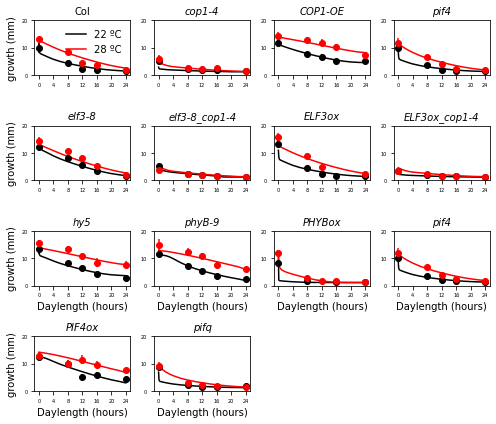

In [35]:
%matplotlib inline
fig=plt.figure(figsize=(7,6))
ncols=4
nrows=4
for i1,mut in enumerate(mutants):
    ax=fig.add_subplot(nrows,ncols,i1+1)
    #PLOT SIMULATIONS PYTHON
    hp22=[]
    hp28=[]
    for D in Daylength2:
        key22='22_'+str(D)
        key28='28_'+str(D)
        hp22.append(hypo_python[mut][key22])
        hp28.append(hypo_python[mut][key28])  
    ax.plot(Daylength2, hp22, 'k', label='22 ºC')
    ax.plot(Daylength2, hp28, 'r', label='28 ºC')
    #DATA
    d22=[]
    d28=[]
    s22=[]
    s28=[]
    for D in Daylength:
        key22='22_'+str(D)
        key28='28_'+str(D)
        if mut in avgdata:
            d22.append(avgdata[mut][key22])
            d28.append(avgdata[mut][key28])
            s22.append(stddata[mut][key22])
            s28.append(stddata[mut][key28])
    if mut in avgdata:
        ax.errorbar(Daylength, d22, yerr=s22, fmt='o', color='k')
        ax.errorbar(Daylength, d28, yerr=s28, fmt='o', color='r')
    if mut=='Col':
        ax.set_title(mut, size=10)
    else:
        ax.set_title(mut, style='italic', size=10)
    ax.set_ylim([0,20])
    if i1==0:
        ax.legend(loc='upper right', frameon=False)
    if i1>7:
        ax.set_xlabel('Daylength (hours)', size=10)
    if i1%4==0:
        ax.set_ylabel('growth (mm)', size=10)
    ax.set_xticks([0,4,8,12,16,20,24])
    ax.set_xticklabels([0,4,8,12,16,20,24], size=5)
    # setting label format to integer with 0 folating decimals
    label_format = '{:,.0f}'
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels([label_format.format(x) for x in ticks_loc], size=5)
    
fig.tight_layout()

### FIGURE 2 – PROTEIN DYNAMICS IN SHORT DAY

In [36]:
time=np.linspace(0,120,500)
mut='Col'
B22=tot_python[mut]['22_8'][:,0]
B28=tot_python[mut]['28_8'][:,0]
E22=tot_python[mut]['22_8'][:,1]
E28=tot_python[mut]['28_8'][:,1]
P22=tot_python[mut]['22_8'][:,2]
P28=tot_python[mut]['28_8'][:,2]
C22=tot_python[mut]['22_8'][:,3]
C28=tot_python[mut]['28_8'][:,3]
G22=tot_python[mut]['22_8'][:,4]
G28=tot_python[mut]['28_8'][:,4]

#### WRITE RESULTS

In [38]:
DF=pd.DataFrame({'Time':time, 'phyb22':B22, 'phyb28':B28,
                 'ELF322':E22, 'ELF328':E28, 'PIF422':P22,
                 'PIF428':P28, 'COP122':C22, 'COP128':C28})
DF.to_csv('./hypo_results_short_day_proteins.csv', float_format='%.3f', index=False)

with pd.ExcelWriter('./hypo_results_short_day_proteins.xlsx') as writer:
    DF.to_excel(writer, float_format='%.3f', index=False)

#### PLOT RESULTS

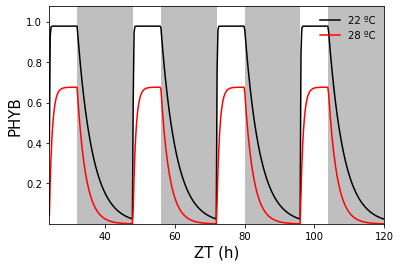

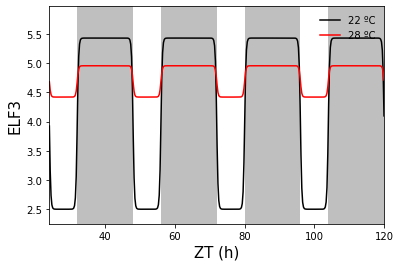

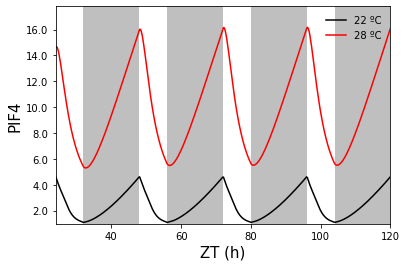

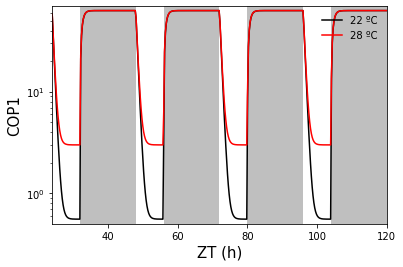

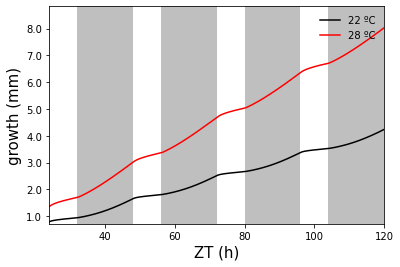

In [39]:
%matplotlib inline
def modsavefigs(time, b22, b28, Daylength, Title):
    xmin=24
    xmax=120
    mask=(time>=xmin) & (time<=xmax)
    Time=time[mask]
    B22=b22[mask]
    B28=b28[mask]
    fig=plt.figure()
    ax=plt.gca()
    ax.plot(Time,B22,'k', label='22 ºC')
    ax.plot(Time,B28,'r', label='28 ºC')
    #
    for days in range(0,5):
        time_day=np.linspace(days*24+Daylength,(days*24)+24, 100)
        ax.fill_between(time_day, 0, 10000, facecolor='grey', alpha=0.5)
    ax.set_ylim([0.9*min(min(B22),min(B28)), 1.10*max(max(B22),max(B28))])
    ax.set_xlabel('ZT (h)', size=15)
    ax.set_ylabel(Title, size=15)
    
    label_format_x = '{:,.0f}'
    label_format_y = '{:,.1f}'
    ticks_loc_x = ax.get_xticks().tolist()
    ticks_loc_y = ax.get_yticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc_x))
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc_y))
    ax.set_xticklabels([label_format_x.format(x) for x in ticks_loc_x], size=10)
    ax.set_yticklabels([label_format_y.format(x) for x in ticks_loc_y], size=10)
    ax.legend(loc='upper right',frameon=False)
    ax.set_xlim([xmin, xmax])
    if Title=='COP1': 
        ax.set_yscale('log')
    #fig.savefig('figures/fig2_'+Title+'_'+suffix+'.pdf', bbox_inches='tight')
modsavefigs(time, B22, B28, 8, 'PHYB')
modsavefigs(time, E22, E28, 8, 'ELF3')
modsavefigs(time, P22, P28, 8, 'PIF4')
modsavefigs(time, C22, C28, 8, 'COP1')
modsavefigs(time, G22, G28, 8, 'growth (mm)')

### SUPPFIG 2 - PROTEIN DYNAMICS IN LONG DAY

For WT plants

In [40]:
time=np.linspace(0,120,500)
B22=tot_python['Col']['22_16'][:,0]
B28=tot_python['Col']['28_16'][:,0]
E22=tot_python['Col']['22_16'][:,1]
E28=tot_python['Col']['28_16'][:,1]
P22=tot_python['Col']['22_16'][:,2]
P28=tot_python['Col']['28_16'][:,2]
C22=tot_python['Col']['22_16'][:,3]
C28=tot_python['Col']['28_16'][:,3]
G22=tot_python['Col']['22_16'][:,4]
G28=tot_python['Col']['28_16'][:,4]

#### WRITE RESULTS

In [42]:
DF=pd.DataFrame({'Time':time, 'phyb22':B22, 'phyb28':B28,
                 'ELF322':E22, 'ELF328':E28, 'PIF422':P22,
                 'PIF428':P28, 'COP122':C22, 'COP128':C28})
DF.to_csv('./hypo_results_long_day_proteins.csv', float_format='%.3f', index=False)

with pd.ExcelWriter('./hypo_results_long_day_proteins.xlsx') as writer:
    DF.to_excel(writer, float_format='%.3f', index=False)

In [43]:
DF

,Time,phyb22,phyb28,ELF322,ELF328,PIF422,PIF428,COP122,COP128
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.240481,0.893878,0.177500,3.274776,4.555707,0.105068,0.209885,0.195440,1.049526
2,0.480962,0.970201,0.308371,2.789421,4.472664,0.197037,0.409943,0.322554,1.732135
3,0.721443,0.976718,0.404862,2.592851,4.436712,0.285669,0.601096,0.405228,2.176102
4,0.961924,0.977274,0.476006,2.527659,4.424785,0.367403,0.781653,0.458999,2.464856
...,...,...,...,...,...,...,...,...,...
495,119.038076,0.190945,0.037453,5.410191,4.952119,2.092170,7.518040,62.820673,62.820682
496,119.278557,0.180584,0.033928,5.364605,4.943780,2.147503,7.704457,62.820748,62.820753
497,119.519038,0.170785,0.030735,5.222877,4.917852,2.204557,7.892321,62.820796,62.820799
498,119.759519,0.161517,0.027842,4.839339,4.847687,2.265089,8.081687,62.820827,62.820829


#### PLOT

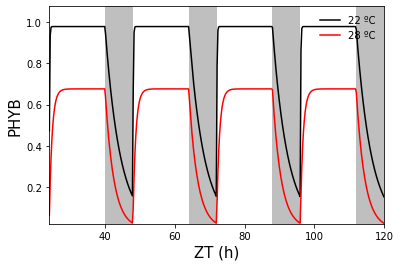

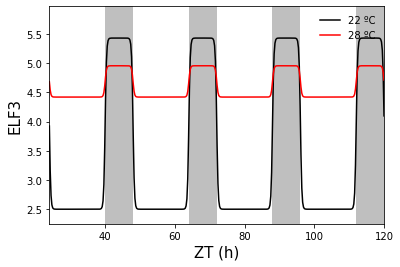

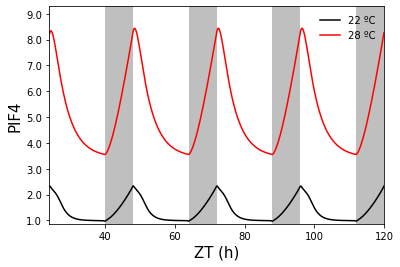

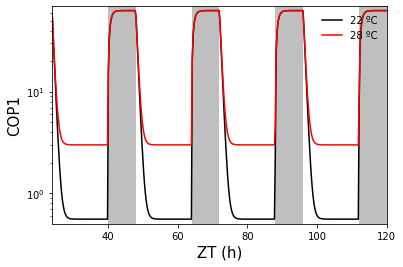

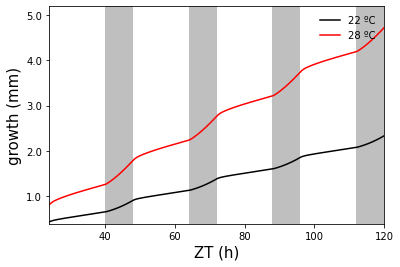

In [44]:
modsavefigs(time, B22, B28, 16, 'PHYB')
modsavefigs(time, E22, E28, 16, 'ELF3')
modsavefigs(time, P22, P28, 16, 'PIF4')
modsavefigs(time, C22, C28, 16, 'COP1')
modsavefigs(time, G22, G28, 16, 'growth (mm)')

<a id='calling_matlab' ></a>
## <font color='lightseagreen'>CALLING MATLAB CODE FROM PYTHON</font>

Initially, I had attempted to import the outputs from the clock model and feed them directly into the hypocotyl elongation model. This method proved to be unsuccessful as the the ode23 solver from matlab uses flexible timesteps in order to solve the differential equations, while the solver used in the hyptoctyl elongation model uses fixed timesteps. Thus could be worked around as definitive time steps can be defined for the ode23 solver, however, this method is not the most robust. The results of this attempt are shown below. 
<br> 

Instead, the hypocotyl elongation model as defined above was combined with the clock model (clock_linked_growth_model.m and all_params.m files as found on github) and the joint system was solved using the ode23 solver. For more details and results, continue to [Joint Matlab Model](#joint_matlab_model) 

### Flexible timesteps
https://uk.mathworks.com/matlabcentral/answers/92961-how-do-i-use-a-fixed-step-size-with-ode23-and-ode45-in-matlab

Text(0.5, 1.0, 'Flexible Time Steps')

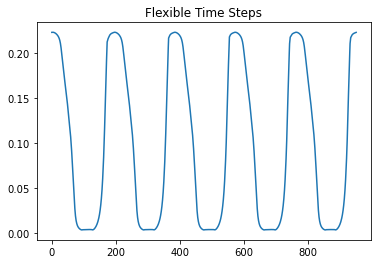

In [53]:
eng = matlab.engine.start_matlab()
path = '/Users/chloe/Desktop/thesis'
eng.cd(path, nargout=0)
clock_model_test = eng.clock_model_test(nargout=0)
time_steps = pd.Series(eng.workspace['T'])
num_days = eng.workspace['t'][0][1]
time_steps = time_steps.apply(lambda x: x[0])
clock_protein_levels = eng.workspace['Y']
df_cpl = pd.DataFrame.from_records(clock_protein_levels)

clock_outputs = 'LHY mRNA,P,GI-ZTL,GI-ELF3 cytoplasm,LHY prot,TOC1 mRNA,PRR9 prot,PRR5 (NI) mRNA,PRR5 (NI) prot,GI prot cytoplasm,TOC1 prot,ZTL,EC,GI mRNA,PRR9 mRNA,PRR7 mRNA,PRR7 prot,ELF4 mRNA,ELF4 prot,LHY prot modif,ABAR mRNA,COP1 cytoplasm,ELF3 mRNA,ELF3 cytoplasm,ELF3 nuclear,COP1 nuclear night,COP1 nuclear day,LUX mRNA,LUX prot,PP2C prot,SnRK2 prot,stomata'

def add_clock_header(df, clock_outputs): 
    clock_outputs = clock_outputs.split(',')
    unknown_outputs = ['?', '?', '?']
    clock_outputs = clock_outputs + unknown_outputs
    header = []
    for item in clock_outputs: 
        item = item.replace(" ", '_')
        header.append(item)
    df.columns = header

add_clock_header(df_cpl, clock_outputs)
    
df_cpl['time_steps'] = time_steps
df_cpl = df_cpl[['time_steps']+[x for x in df_cpl.columns if x != 'time_steps']]

ELF3_nuc = df_cpl[['time_steps', 'ELF3_nuclear']]
# plotting against index 
ELF3_nuc.ELF3_nuclear.plot()
plt.title('Flexible Time Steps')

In [52]:
df_cpl

,time_steps,LHY_mRNA,P,GI-ZTL,GI-ELF3_cytoplasm,LHY_prot,TOC1_mRNA,PRR9_prot,PRR5_(NI)_mRNA,PRR5_(NI)_prot,...,stomata,?,?,?,?,?,?,?,?,?
0,0.000000,0.954800,0.956000,0.076800,0.020600,0.500500,0.065600,0.025100,0.150200,0.069900,...,0.284300,0.1342,0.476400,0.031900,0.1342,0.476400,0.031900,0.1342,0.476400,0.031900
1,0.005779,0.957357,0.953120,0.076848,0.020532,0.501555,0.065502,0.025290,0.150464,0.070072,...,0.284992,0.1342,0.476900,0.032806,0.1342,0.476900,0.032806,0.1342,0.476900,0.032806
2,0.018627,0.963726,0.945635,0.077002,0.020368,0.504059,0.065285,0.025825,0.151055,0.070494,...,0.286777,0.1342,0.478297,0.035299,0.1342,0.478297,0.035299,0.1342,0.478297,0.035299
3,0.030823,0.970502,0.937323,0.077201,0.020197,0.506623,0.065080,0.026495,0.151621,0.070943,...,0.288750,0.1342,0.479994,0.038334,0.1342,0.479994,0.038334,0.1342,0.479994,0.038334
4,0.043146,0.977856,0.928008,0.077442,0.020012,0.509368,0.064873,0.027351,0.152197,0.071434,...,0.290957,0.1342,0.482057,0.042077,0.1342,0.482057,0.042077,0.1342,0.482057,0.042077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,119.957542,0.942818,0.968292,0.076854,0.020953,0.494785,0.066202,0.024345,0.148527,0.068952,...,0.281237,0.1342,0.474666,0.028320,0.1342,0.474666,0.028320,0.1342,0.474666,0.028320
948,119.966764,0.944869,0.966756,0.076798,0.020883,0.496052,0.066045,0.024439,0.148940,0.069114,...,0.281646,0.1342,0.474815,0.028740,0.1342,0.474815,0.028740,0.1342,0.474815,0.028740
949,119.976498,0.947430,0.964545,0.076765,0.020802,0.497467,0.065879,0.024571,0.149379,0.069306,...,0.282211,0.1342,0.475084,0.029354,0.1342,0.475084,0.029354,0.1342,0.475084,0.029354
950,119.987135,0.950789,0.961288,0.076765,0.020703,0.499126,0.065698,0.024767,0.149861,0.069547,...,0.283018,0.1342,0.475546,0.030285,0.1342,0.475546,0.030285,0.1342,0.475546,0.030285


### Re-ran with fixed time intervals

Text(0.5, 1.0, 'Fixed Time Steps')

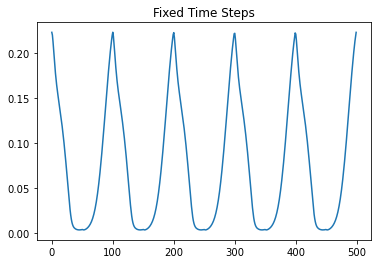

In [46]:
eng = matlab.engine.start_matlab()
path = '/Users/chloe/Desktop/thesis'
eng.cd(path, nargout=0)
clock_model_test = eng.clock_model_test_fixed_t(nargout=0)
time_steps = pd.Series(eng.workspace['T'])
num_days = eng.workspace['t'][0][1]
time_steps = time_steps.apply(lambda x: x[0])
clock_protein_levels = eng.workspace['Y']
df_cpl = pd.DataFrame.from_records(clock_protein_levels)

clock_outputs = 'LHY mRNA,P,GI-ZTL,GI-ELF3 cytoplasm,LHY prot,TOC1 mRNA,PRR9 prot,PRR5 (NI) mRNA,PRR5 (NI) prot,GI prot cytoplasm,TOC1 prot,ZTL,EC,GI mRNA,PRR9 mRNA,PRR7 mRNA,PRR7 prot,ELF4 mRNA,ELF4 prot,LHY prot modif,ABAR mRNA,COP1 cytoplasm,ELF3 mRNA,ELF3 cytoplasm,ELF3 nuclear,COP1 nuclear night,COP1 nuclear day,LUX mRNA,LUX prot,PP2C prot,SnRK2 prot,stomata'

def add_clock_header(df, clock_outputs): 
    clock_outputs = clock_outputs.split(',')
    unknown_outputs = ['?', '?', '?']
    clock_outputs = clock_outputs + unknown_outputs
    header = []
    for item in clock_outputs: 
        item = item.replace(" ", '_')
        header.append(item)
    df.columns = header

add_clock_header(df_cpl, clock_outputs)
    
df_cpl['time_steps'] = time_steps
df_cpl = df_cpl[['time_steps']+[x for x in df_cpl.columns if x != 'time_steps']]

ELF3_nuc = df_cpl[['time_steps', 'ELF3_nuclear']]
# plotting against index 
ELF3_nuc.ELF3_nuclear.plot()
plt.title('Fixed Time Steps')

In [47]:
ELF3_nuc

,time_steps,ELF3_nuclear
0,0.000000,0.223400
1,0.240481,0.220366
2,0.480962,0.213047
3,0.721443,0.203964
4,0.961924,0.194610
...,...,...
495,119.038076,0.201046
496,119.278557,0.207534
497,119.519038,0.213503
498,119.759519,0.218908


We need to retrieve the expression values of ELF3 at 500 different timepoints that are equally spaced over a 120 hour period. The only problem with this, when trying to integrate the models, is that ode23 uses a flexible solver that does not use a fixed timestep – 

<a id='joint_matlab_model'></a>
## <font color='lightseagreen'>JOINT MATLAB MODEL</font>

The above hypocotyl elongation model was linked to the plant circadian clock model developed by Pokhilko et al. 2013 and solved using ode23 solver in matlab. The ad hoc expression profiles of ELF3 and COP1 were replaced by those generated via the clock model. Specifically, ELF3 dynamics were set to equal the ELF3 nuclear concentrations as defined by y(25) and COP1 was set to be the sum of the light and dark nuclear proteins given by y(26) and y(27). The starting concentrations of these, while 0 in the hypocotyl elongation model, were set to equal the corresponding initial values as defined in Pokhilko et al – (0.2234 and 1.2513 respectively). 

This model can be found in the **clock_linked_growth_model.m** and **all_params.m** files on my [github](https://github.com/cbantock/arabidopsis_clock_growth_model)


The Matlab engine for python is used in order to call and run the model in matlab and then subsequently import the outputs of the model to a jupyter notebook for further analysis and comparison to the unlinked hypocotyl elongation model. 


In [39]:
#starting engine
eng = matlab.engine.start_matlab()
path = '/Users/chloe/Desktop/thesis'
eng.cd(path, nargout=0)

#calling the linked growth model 
linked_growth_model = eng.all_params(nargout=0)

### Extracting MATLAB outputs 

Extracting the timesteps and protein levels for each simulation run. Simulations were run for the following different daylengths: 

* 0L/24D
* 4L/20D
* 8L/16D
* 12L/12L
* 16L/8D
* 20L/4D
* 24L


In [145]:
# consistent for all runs 
num_days = eng.workspace['t'][0][1]
daylength = np.arange(0,28,4).tolist()
sim_time_points = []
daylength_sims = []
for i in daylength: 
    daylength_sims.append('Y'+str(i))
    sim_time_points.append('T'+str(i))
sim_time_points


['T0', 'T4', 'T8', 'T12', 'T16', 'T20', 'T24']

In [146]:
def get_outputs(model, sim_names, sim_time_points): 
    sim_outputs = {}
    for (name, time) in zip(sim_names, sim_time_points): 
        sim_outputs[name] = {}
        sim_outputs[name]['time_steps'] = pd.Series(eng.workspace[time]).apply(lambda x: x[0])
        sim_outputs[name]['prot_dyn'] = eng.workspace[name]
    return sim_outputs

In [148]:
sim_outputs = get_outputs(linked_growth_model, daylength_sims, sim_time_points)


In [149]:
clock_outputs = 'LHY mRNA,P,GI-ZTL,GI-ELF3 cytoplasm,LHY prot,TOC1 mRNA,PRR9 prot,PRR5 (NI) mRNA,PRR5 (NI) prot,GI prot cytoplasm,TOC1 prot,ZTL,EC,GI mRNA,PRR9 mRNA,PRR7 mRNA,PRR7 prot,ELF4 mRNA,ELF4 prot,LHY prot modif,ABAR mRNA,COP1 cytoplasm,ELF3 mRNA,ELF3 cytoplasm,ELF3 nuclear,COP1 nuclear night,COP1 nuclear day,LUX mRNA,LUX prot,PP2C prot,SnRK2 prot,stomata,?,?,?,PHYB,ELF3,PIF,COP1,growth'

clock_outputs = clock_outputs.split(',')
clock_outputs
header = ['time_steps']
for item in clock_outputs: 
    item = item.replace(" ", '_')
    header.append(item)

In [150]:
def create_df(output_dict, sim): 
    sim_df = pd.concat([pd.DataFrame(output_dict[sim]['time_steps']), pd.DataFrame(output_dict[sim]['prot_dyn'])],axis=1)
    sim_df.columns=(header)
    return sim_df
    

In [151]:
Y0 = create_df(sim_outputs,'Y0')
Y4 = create_df(sim_outputs,'Y4')
Y8 = create_df(sim_outputs,'Y8')
Y12 = create_df(sim_outputs,'Y12')
Y16 = create_df(sim_outputs,'Y16')
Y20 = create_df(sim_outputs,'Y20')
Y24 = create_df(sim_outputs,'Y24')

In [152]:
Y0

,time_steps,LHY_mRNA,P,GI-ZTL,GI-ELF3_cytoplasm,LHY_prot,TOC1_mRNA,PRR9_prot,PRR5_(NI)_mRNA,PRR5_(NI)_prot,...,SnRK2_prot,stomata,?,?,?,PHYB,ELF3,PIF,COP1,growth
0,0.000000,0.954800,0.956000,0.076800,0.020600,0.500500,0.065600,0.025100,0.150200,0.069900,...,0.236200,0.284300,0.1342,0.476400,0.031900,0.000000,0.223400,0.000000,1.251300,0.000000
1,0.010757,0.955762,0.956142,0.076651,0.020482,0.501754,0.065418,0.025412,0.150693,0.070021,...,0.236253,0.284333,0.1342,0.477256,0.033283,0.000000,0.223493,0.010007,1.247132,0.000098
2,0.029126,0.957364,0.956383,0.076398,0.020298,0.503893,0.065108,0.025936,0.151541,0.070232,...,0.236344,0.284388,0.1342,0.478706,0.034950,0.000000,0.223655,0.027067,1.240189,0.000265
3,0.050425,0.959156,0.956661,0.076106,0.020110,0.506369,0.064751,0.026527,0.152535,0.070482,...,0.236452,0.284452,0.1342,0.480369,0.036128,0.000000,0.223844,0.046803,1.232410,0.000461
4,0.075761,0.961200,0.956989,0.075760,0.019915,0.509307,0.064329,0.027210,0.153733,0.070788,...,0.236584,0.284525,0.1342,0.482322,0.036892,0.000000,0.224075,0.070214,1.223525,0.000695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,119.998348,0.264862,0.983734,0.005503,0.045814,0.304741,0.185769,0.097184,0.446201,0.249527,...,0.465966,0.172213,0.1342,0.411054,0.028435,0.151601,0.008148,9.559536,1.412474,3.802834
533,119.999018,0.265149,0.983415,0.005607,0.045807,0.304745,0.185782,0.097204,0.446189,0.249562,...,0.465969,0.172251,0.1342,0.411115,0.028528,0.154340,0.008148,9.559263,1.412290,3.802857
534,119.999689,0.265440,0.983091,0.005713,0.045800,0.304750,0.185794,0.097224,0.446178,0.249598,...,0.465971,0.172289,0.1342,0.411176,0.028623,0.157108,0.008149,9.558983,1.412106,3.802880
535,119.999909,0.265537,0.982984,0.005748,0.045797,0.304752,0.185798,0.097230,0.446174,0.249610,...,0.465972,0.172302,0.1342,0.411197,0.028655,0.158024,0.008149,9.558890,1.412046,3.802888


In [244]:
linked_growth_12 = Y12[['time_steps', 'PHYB', 'ELF3', 'PIF', 'COP1', 'growth']]
linked_growth_12

,time_steps,PHYB,ELF3,PIF,COP1,growth
0,0.000000,0.000000,0.223400,0.000000,1.251300,0.000000
1,0.000417,0.002089,0.223404,0.000388,1.251212,0.000004
2,0.002499,0.012723,0.223421,0.002326,1.250771,0.000023
3,0.008367,0.044276,0.223463,0.007785,1.249526,0.000076
4,0.016182,0.089400,0.223506,0.015047,1.247924,0.000147
...,...,...,...,...,...,...
950,119.964212,0.109356,0.222941,4.957233,1.257305,2.146775
951,119.973749,0.127955,0.223083,4.959101,1.256106,2.147001
952,119.984163,0.154559,0.223220,4.960767,1.254413,2.147248
953,119.995777,0.192603,0.223348,4.962029,1.252137,2.147523


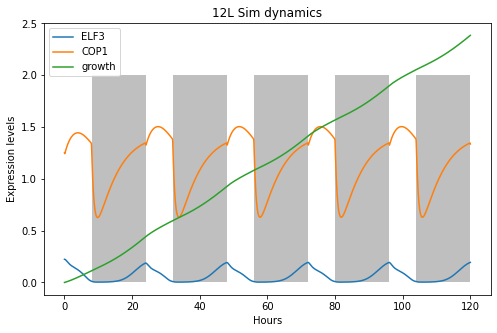

In [186]:
# results for 12L/12D
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(linked_growth_12['time_steps'], linked_growth_12['ELF3'], label='ELF3')
ax.plot(linked_growth_12['time_steps'], linked_growth_12['COP1'], label='COP1')
ax.plot(linked_growth_12['time_steps'], linked_growth_12['growth'], label='growth')
plt.title('12L Sim dynamics')
plt.xlabel('Hours')
plt.ylabel('Expression levels')

for days in range(0,5):
    time_day=np.linspace(days*24+12,(days*24)+24, 100)
    ax.fill_between(time_day, 0, 2, facecolor='grey', alpha=0.5)
plt.legend()

In [245]:
#plt.plot(linked_growth_12['time_steps'], linked_growth_12['ELF3'])

### Comparison to original growth model 

#### Import data for WT simultions 
(mut = 'Col')

In [156]:
# retrieve experimental data
hypo_results_long_day_url = 'https://raw.githubusercontent.com/cbantock/arabidopsis_clock_growth_model/main/hypo_results_long_day_proteins.csv'
hypo_results_long_day_data = requests.get(hypo_results_long_day_url).content
hypo_results_long_day_df = pd.read_csv(io.StringIO(hypo_results_long_day_data.decode('utf-8')))

In [157]:
hypo_results_long_day_df

,Time,phyb22,phyb28,ELF322,ELF328,PIF422,PIF428,COP122,COP128
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.240,0.894,0.177,3.275,4.556,0.105,0.210,0.195,1.050
2,0.481,0.970,0.308,2.789,4.473,0.197,0.410,0.323,1.732
3,0.721,0.977,0.405,2.593,4.437,0.286,0.601,0.405,2.176
4,0.962,0.977,0.476,2.528,4.425,0.367,0.782,0.459,2.465
...,...,...,...,...,...,...,...,...,...
495,119.038,0.191,0.037,5.410,4.952,2.092,7.518,62.821,62.821
496,119.279,0.181,0.034,5.365,4.944,2.148,7.704,62.821,62.821
497,119.519,0.171,0.031,5.223,4.918,2.205,7.892,62.821,62.821
498,119.760,0.162,0.028,4.839,4.848,2.265,8.082,62.821,62.821


In [158]:
hypo_results_short_day_url='https://raw.githubusercontent.com/cbantock/arabidopsis_clock_growth_model/main/hypo_results_short_day_proteins.csv'
hypo_results_short_day_data = requests.get(hypo_results_short_day_url).content
hypo_results_short_day_df = pd.read_csv(io.StringIO(hypo_results_short_day_data.decode('utf-8')))

In [159]:
hypo_results_short_day_df

,Time,phyb22,phyb28,ELF322,ELF328,PIF422,PIF428,COP122,COP128
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.240,0.894,0.177,3.275,4.556,0.105,0.210,0.195,1.050
2,0.481,0.970,0.308,2.789,4.473,0.197,0.410,0.323,1.732
3,0.721,0.977,0.405,2.593,4.437,0.286,0.601,0.405,2.176
4,0.962,0.977,0.476,2.528,4.425,0.367,0.782,0.459,2.465
...,...,...,...,...,...,...,...,...,...
495,119.038,0.030,0.001,5.410,4.952,4.306,15.287,62.821,62.821
496,119.279,0.028,0.001,5.365,4.944,4.380,15.488,62.821,62.821
497,119.519,0.027,0.001,5.223,4.918,4.456,15.689,62.821,62.821
498,119.760,0.025,0.001,4.839,4.848,4.534,15.890,62.821,62.821


In [160]:
DFdata_22 = DFdata[DFdata['Temperature']==22]
DFdata_22                   

,Daylength,Temperature,Average Growth (experimental),Standard Deviation Growth (experimental),Model prediction
0,0.0,22,8.589833,0.768281,6.852545
2,0.1,22,NaN,NaN,4.254689
4,0.2,22,NaN,NaN,3.723258
6,0.3,22,NaN,NaN,3.548029
8,0.4,22,NaN,NaN,3.467705
10,0.5,22,NaN,NaN,3.417990
12,1.0,22,NaN,NaN,3.248613
14,2.0,22,NaN,NaN,2.964004
16,3.0,22,NaN,NaN,2.711681
18,4.0,22,NaN,NaN,2.497081


#### **Plots for short day** 

dusk = 8 
<br>
8L, 16D conditions 

In [246]:
linked_growth_8 = Y8[['time_steps', 'PHYB', 'ELF3', 'PIF', 'COP1', 'growth']]

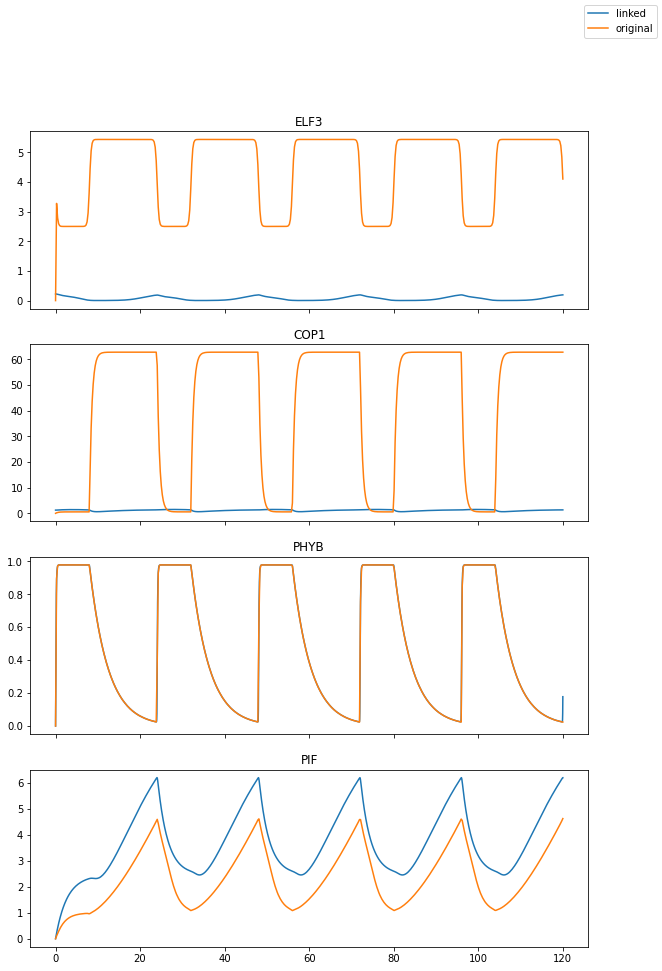

In [249]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,15))

# ELF3
ax[0].plot(linked_growth_8['time_steps'], linked_growth_8['ELF3'], label = 'joint')
ax[0].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['ELF322'], label = 'original')
#ax[0].legend(loc='best')
ax[0].set_title('ELF3')

# COP1
ax[1].plot(linked_growth_8['time_steps'], linked_growth_8['COP1'], label = 'joint' )
ax[1].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['COP122'], label = 'original')
#ax[1].legend(loc='best')
ax[1].set_title('COP1')

# PHYB
ax[2].plot(linked_growth_8['time_steps'], linked_growth_8['PHYB'], label = 'joint' )
ax[2].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['phyb22'], label = 'original')
#ax[2].legend(loc='best')
ax[2].set_title('PHYB')

# PIF
ax[3].plot(linked_growth_8['time_steps'], linked_growth_8['PIF'], label = 'joint' )
ax[3].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['PIF422'], label = 'original')
#ax[3].legend(loc='best')
ax[3].set_title('PIF')

fig.legend(labels = ['linked', 'original'])

##### **Rescaled**

Text(0.5, 0.98, 'Protein dynamics in short day –\xa08L/16D')

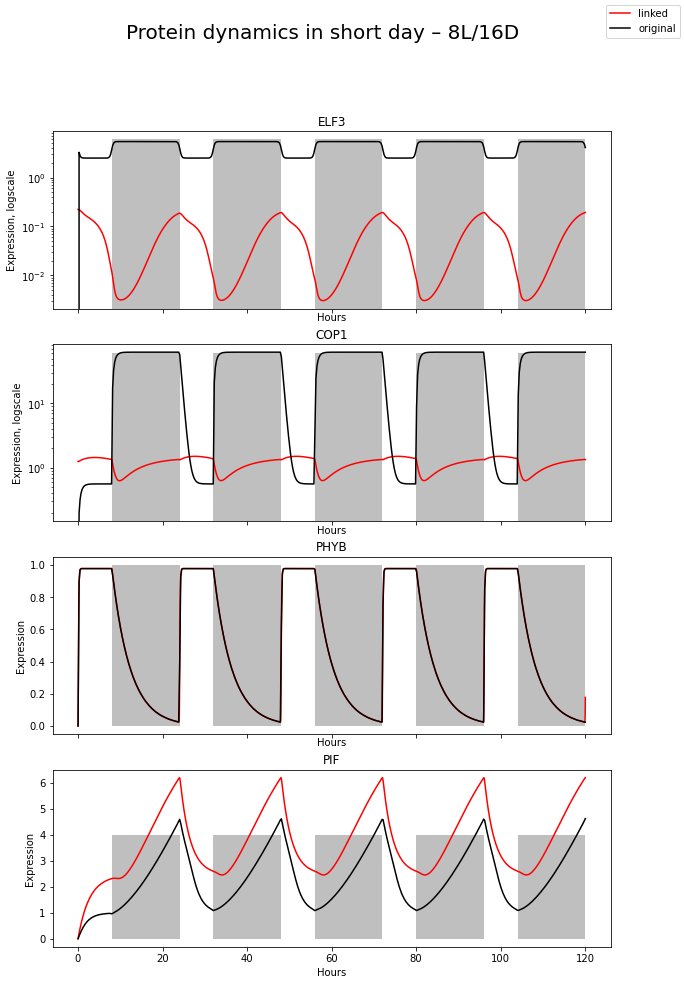

In [316]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,15))

# ELF3
ax[0].plot(linked_growth_8['time_steps'], linked_growth_8['ELF3'], label = 'joint', color='red')
ax[0].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['ELF322'], label = 'original', color='k')
#ax[0].legend(loc='best')
ax[0].set_yscale('log')
ax[0].set_ylabel('Expression, logscale')
ax[0].set_xlabel('Hours')
ax[0].set_title('ELF3')
for days in range(0,5):
    time_day=np.linspace(days*24+8,(days*24)+24, 100)
    ax[0].fill_between(time_day, 0, 6, facecolor='grey', alpha=0.5)

# COP1
ax[1].plot(linked_growth_8['time_steps'], linked_growth_8['COP1'], label = 'joint', color='red' )
ax[1].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['COP122'], label = 'original', color='k')
#ax[1].legend(loc='best')
ax[1].set_ylabel('Expression, logscale')
ax[1].set_xlabel('Hours')
ax[1].set_yscale('log')
ax[1].set_title('COP1')
for days in range(0,5):
    time_day=np.linspace(days*24+8,(days*24)+24, 100)
    ax[1].fill_between(time_day, 0, 60, facecolor='grey', alpha=0.5)

# PHYB
ax[2].plot(linked_growth_8['time_steps'], linked_growth_8['PHYB'], label = 'joint', color='red')
ax[2].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['phyb22'], label = 'original', color='k')
#ax[2].legend(loc='best')
ax[2].set_ylabel('Expression')
ax[2].set_xlabel('Hours')
ax[2].set_title('PHYB')
for days in range(0,5):
    time_day=np.linspace(days*24+8,(days*24)+24, 100)
    ax[2].fill_between(time_day, 0, 1, facecolor='grey', alpha=0.5)

# PIF
ax[3].plot(linked_growth_8['time_steps'], linked_growth_8['PIF'], label = 'joint', color='red' )
ax[3].plot(hypo_results_short_day_df['Time'], hypo_results_short_day_df['PIF422'], label = 'original', color='k')
#ax[3].legend(loc='best')
ax[3].set_ylabel('Expression')
ax[3].set_xlabel('Hours')
ax[3].set_title('PIF')
for days in range(0,5):
    time_day=np.linspace(days*24+8,(days*24)+24, 100)
    ax[3].fill_between(time_day, 0, 4, facecolor='grey', alpha=0.5)

fig.legend(labels = ['linked', 'original'])

plt.suptitle('Protein dynamics in short day – 8L/16D', size=20)

#### **Plots for long day** 

In [193]:
linked_growth_16 = Y16[['time_steps', 'PHYB', 'ELF3', 'PIF', 'COP1', 'growth']]

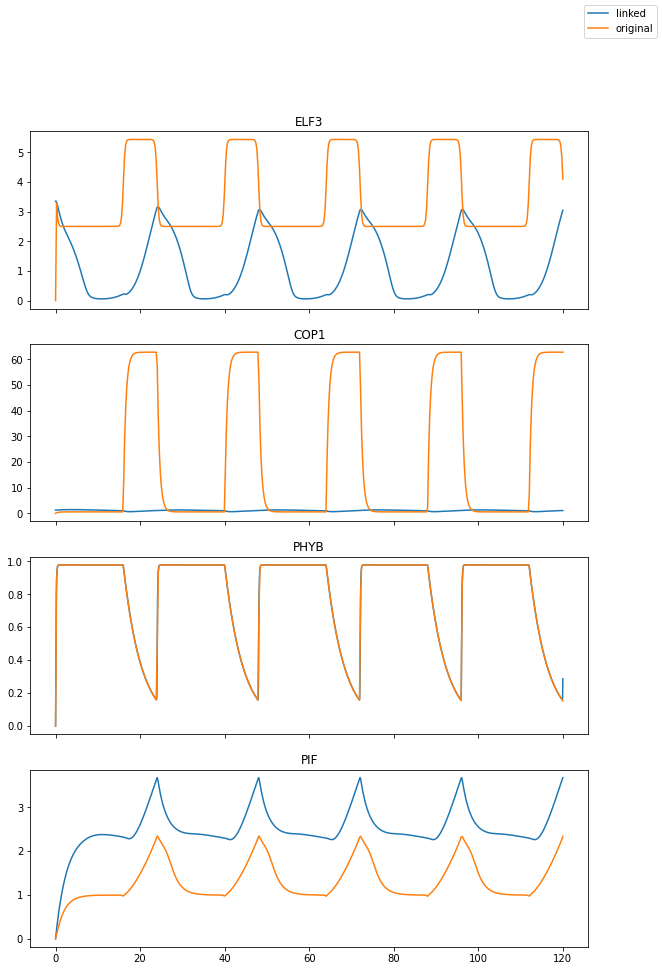

In [311]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,15))

# ELF3
ax[0].plot(linked_growth_16['time_steps'], linked_growth_16['ELF3'], label = 'joint')
ax[0].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['ELF322'], label = 'original')
#ax[0].legend(loc='best')
ax[0].set_title('ELF3')

# COP1
ax[1].plot(linked_growth_16['time_steps'], linked_growth_16['COP1'], label = 'joint' )
ax[1].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['COP122'], label = 'original')
#ax[1].legend(loc='best')
ax[1].set_title('COP1')

# PHYB
ax[2].plot(linked_growth_16['time_steps'], linked_growth_16['PHYB'], label = 'joint' )
ax[2].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['phyb22'], label = 'original')
#ax[2].legend(loc='best')
ax[2].set_title('PHYB')

# PIF
ax[3].plot(linked_growth_16['time_steps'], linked_growth_16['PIF'], label = 'joint' )
ax[3].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['PIF422'], label = 'original')
#ax[3].legend(loc='best')
ax[3].set_title('PIF')

fig.legend(labels = ['linked', 'original'])

##### **Rescaled** 

Text(0.5, 0.98, 'Protein dynamics in long day –\xa016L/8D')

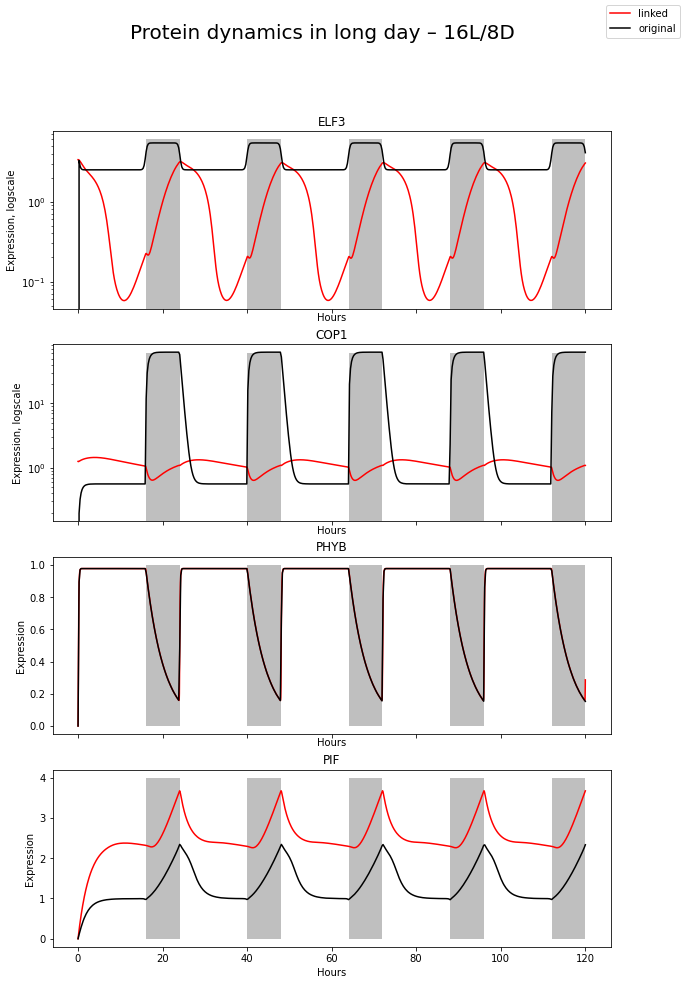

In [313]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,15))

# ELF3
ax[0].plot(linked_growth_16['time_steps'], linked_growth_16['ELF3'], label = 'joint', color='red')
ax[0].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['ELF322'], label = 'original', color='k')
#ax[0].legend(loc='best')
ax[0].set_yscale('log')
ax[0].set_ylabel('Expression, logscale')
ax[0].set_xlabel('Hours')
ax[0].set_title('ELF3')
for days in range(0,5):
    time_day=np.linspace(days*24+16,(days*24)+24, 100)
    ax[0].fill_between(time_day, 0, 6, facecolor='grey', alpha=0.5)

# COP1
ax[1].plot(linked_growth_16['time_steps'], linked_growth_16['COP1'], label = 'joint', color='red' )
ax[1].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['COP122'], label = 'original', color='k')
#ax[1].legend(loc='best')
ax[1].set_ylabel('Expression, logscale')
ax[1].set_xlabel('Hours')
ax[1].set_yscale('log')
ax[1].set_title('COP1')
for days in range(0,5):
    time_day=np.linspace(days*24+16,(days*24)+24, 100)
    ax[1].fill_between(time_day, 0, 60, facecolor='grey', alpha=0.5)

# PHYB
ax[2].plot(linked_growth_16['time_steps'], linked_growth_16['PHYB'], label = 'joint', color='red')
ax[2].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['phyb22'], label = 'original', color='k')
#ax[2].legend(loc='best')
ax[2].set_ylabel('Expression')
ax[2].set_xlabel('Hours')
ax[2].set_title('PHYB')
for days in range(0,5):
    time_day=np.linspace(days*24+16,(days*24)+24, 100)
    ax[2].fill_between(time_day, 0, 1, facecolor='grey', alpha=0.5)

# PIF
ax[3].plot(linked_growth_16['time_steps'], linked_growth_16['PIF'], label = 'joint', color='red' )
ax[3].plot(hypo_results_long_day_df['Time'], hypo_results_long_day_df['PIF422'], label = 'original', color='k')
#ax[3].legend(loc='best')
ax[3].set_ylabel('Expression')
ax[3].set_xlabel('Hours')
ax[3].set_title('PIF')
for days in range(0,5):
    time_day=np.linspace(days*24+16,(days*24)+24, 100)
    ax[3].fill_between(time_day, 0, 4, facecolor='grey', alpha=0.5)

fig.legend(labels = ['linked', 'original'])

plt.suptitle('Protein dynamics in long day – 16L/8D', size=20)

#### Growth vs Daylength

In [236]:
sim_growth = []
sim_outputs = [Y0, Y4, Y8, Y12, Y16, Y20, Y24]
for sim in sim_outputs:
    sim_growth.append(sim['growth'].iloc[-1])
linked_growth_df = pd.DataFrame(sim_growth, daylength, columns=['growth'])



In [237]:
linked_growth_df

,growth
0,3.802891
4,2.648457
8,2.384123
12,2.147623
16,1.965183
20,1.849352
24,1.791869


Text(0, 0.5, 'Growth (mm)')

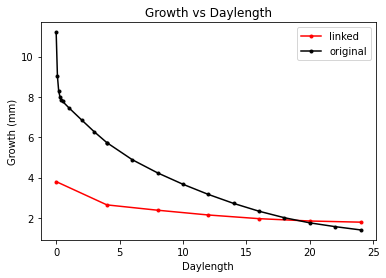

In [252]:
fig, ax = plt.subplots()

ax.plot(daylength,linked_growth_df['growth'], color='red', label = 'linked', marker='.')
hp22=[]
for D in Daylength2:
    key22='22_'+str(D)
    hp22.append(hypo_python['Col'][key22])  
ax.plot(Daylength2, hp22, 'k', label='original', marker='.')
ax.legend(loc='best')
plt.title("Growth vs Daylength")
plt.xlabel('Daylength')
plt.ylabel('Growth (mm)')

#### Comments 

– large discrepancies in expression values for ELF3 and COP1

– ELF3 exhibits softer changes in expression during transition from day to night/night to day. In the hypocotyl model, its expression is modeled as a square wave that peaks at the onset of dusk. In the linked model, ELF3 peaks at the onset of dawn and then steadily declines.

– the COP1 expression profile differs in that expression initially decreases at the onset of dusk, and slowly increases until midday before it begins to slowly decrease until dusk, where it rapidly decreases  whereas in the hypocotyl elongation model, expression peaks during the night and then decreases with the onset of dawn 

– PHYB expression is the same as unlinked model for short day sim as well as the long day simulation 

– the PIF expression profile is consistent in both long and short day simulations, but the absolute value is slightly higher in the linked model

– growth response as a function of daylength not as strong as seen in the original model 

### Mutation Studies 